In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.core.frozen_dict import freeze, unfreeze

!git clone https://github.com/htymjun/da-sr
os.chdir('/content/da-sr')

from read import fw_to_np

Cloning into 'da-sr'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 13), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 9.98 MiB | 13.76 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [24]:
# read cn and fw files
u, v, w, p, t, icount, x, y, z = fw_to_np('data')
# interpolate
uc = 0.5e0*(u[:-1,:,:]+u[1:,:,:])
vc = 0.5e0*(v[:,:-1,:]+v[:,1:,:])
wc = 0.5e0*(w[:,:,:-1]+w[:,:,1:])
xc = 0.5e0*(x[:-1]+x[1:])
yc = 0.5e0*(y[:-1]+y[1:])
zc = 0.5e0*(z[:-1]+z[1:])

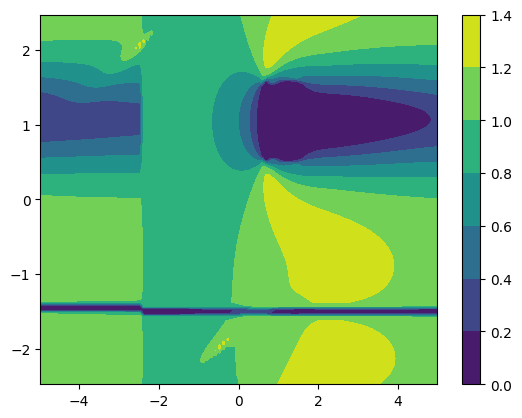

In [25]:
Nz = int(0.5*len(zc))
U = np.sqrt(uc[:,:,Nz]**2+vc[:,:,Nz]**2)
Xc, Yc = np.meshgrid(xc,yc)

fig, ax = plt.subplots()
tcf = ax.contourf(Xc, Yc, np.transpose(U))
fig.colorbar(tcf)

In [101]:
# set_batch
Nx = 5
Ny = 5
ub = uc[:,:,Nz].reshape(-1,5,5)
vb = vc[:,:,Nz].reshape(-1,5,5)
x = np.stack([ub,vb], axis=-1)

# normalize
N = len(x[:,0,0,0])
ave = np.zeros(N)
for i in range(N):
  ave[i] = 0.5e0*(x[i,:,:,0].mean()+x[i,:,:,1].mean())
  x[i,:,:,0] = np.divide(x[i,:,:,0],ave[i])
  x[i,:,:,1] = np.divide(x[i,:,:,1],ave[i])

In [102]:
class ConvolutionLayer(nn.Module):
 filters: np.ndarray

 @nn.compact
 def __call__(self, x):
     x = nn.Conv(features=self.filters.shape[-1], kernel_size=(3,3), strides=(1, 1), padding='SAME')(x)
     return x

In [168]:
# the group p4m
def p4m(m,r,u,v):
  g = np.zeros([3,3])
  m = float(m)
  r = float(r)
  u = float(u)
  v = float(v)
  theta = 0.5e0*np.mod(r,4.e0)*np.pi
  g = [[(-1.e0)**m*np.cos(theta),-(-1.e0)**m*np.sin(theta),   u],
      [            np.sin(theta),            np.cos(theta),   v],
      [                     0.e0,                     0.e0,1.e0]]
  return g

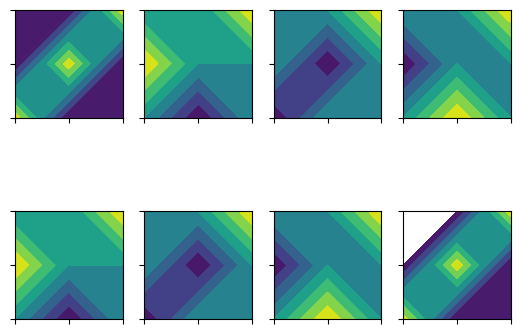

In [169]:
# visualize
Xc, Yc = np.meshgrid(np.linspace(0,1,3),np.linspace(0,1,3))

fig, axes = plt.subplots(2,4)
for i in range(4):
  tcf = axes[0,i].contourf(Xc,Yc,p4m(0,i,0,0))
  axes[0,i].set_aspect('equal')
  axes[0,i].set_xticklabels([])
  axes[0,i].set_yticklabels([])
for i in range(4):
  tcf = axes[1,i].contourf(Xc,Yc,np.matmul(p4m(0,1,0,0),p4m(0,i,0,0)))
  axes[1,i].set_aspect('equal')
  axes[1,i].set_xticklabels([])
  axes[1,i].set_yticklabels([])

In [151]:
# set filter
Nf = 1
filters = np.zeros([Nf,3,3])
for i in range(Nf):
  m = 0
  r = 0
  u = 0
  v = 0
  filters[i,:,:] = p4m(m,r,u,v)

In [154]:
conv_layer = ConvolutionLayer(filters=filters)

# initialize parameter
rng = random.PRNGKey(0)
variables = conv_layer.init(rng, x)

# calc convolution
output1 = conv_layer.apply(variables,np.rot90(x, axes=(1,2)))

In [155]:
conv_layer = ConvolutionLayer(filters=filters)

# initialize parameter
rng = random.PRNGKey(0)
variables = conv_layer.init(rng, x)

# calc convolution
output2 = np.rot90(conv_layer.apply(variables,x), axes=(1,2))

[Text(0, 0.0, ''),
 Text(0, 0.2, ''),
 Text(0, 0.4, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0, '')]

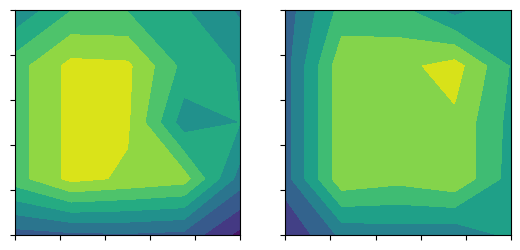

In [156]:
# visualize
Xc, Yc = np.meshgrid(np.linspace(0,1,5),np.linspace(0,1,5))

fig, axes = plt.subplots(1,2)
tcf = axes[0].contourf(Xc, Yc, output1[0,:,:,0])
axes[0].set_aspect('equal')
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
tcf = axes[1].contourf(Xc, Yc, output2[0,:,:,0])
axes[1].set_aspect('equal')
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])